In [1]:
# import libraries
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

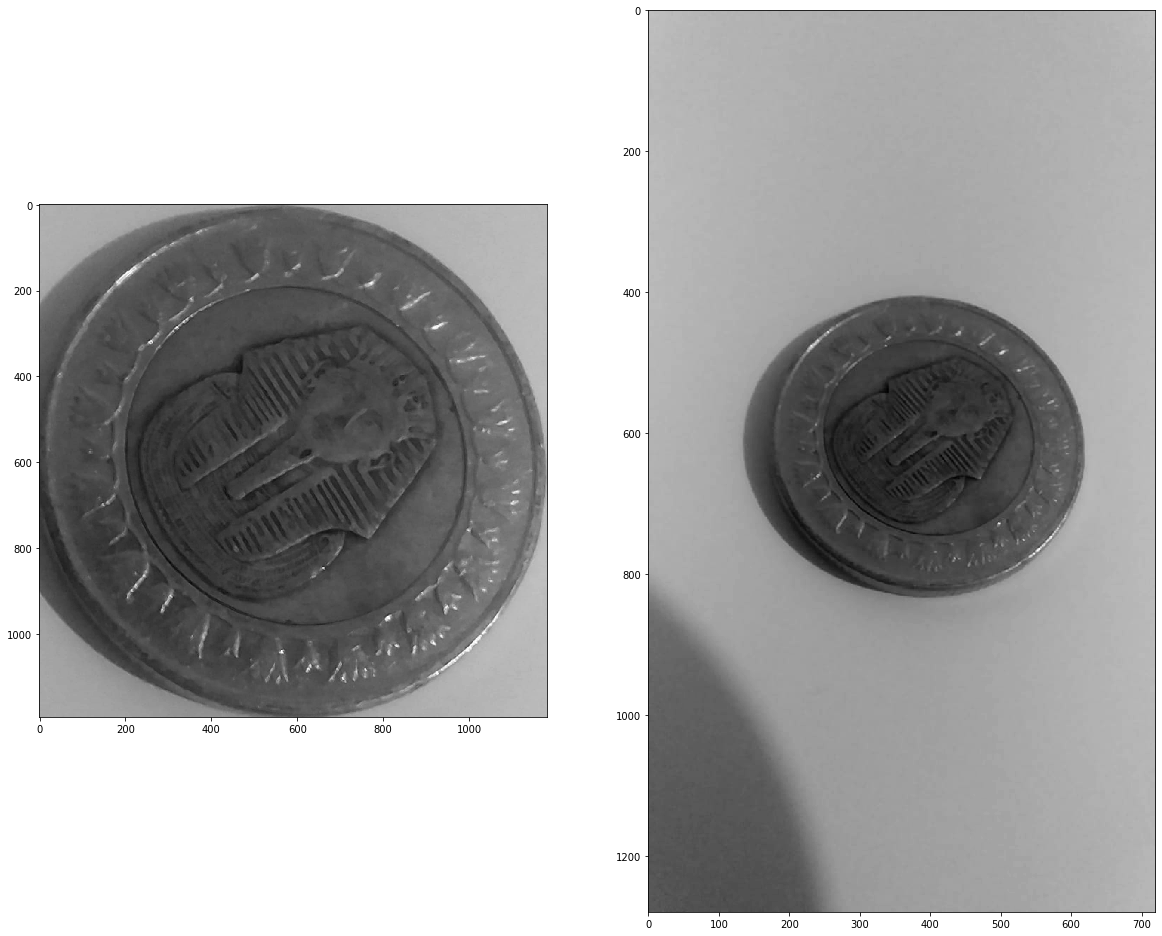

In [2]:
# read and plot images
img1=cv2.imread("20.jpeg",0)
img2=cv2.imread("16.jpeg",0)

plt.figure(figsize=(20,20))



plt.subplot(1,2,1)
plt.imshow(img1,"gray")

plt.subplot(1,2,2)
plt.imshow(img2,"gray")

In [3]:
print("img1 shape => ",img1.shape)
print("------------------------------")
print("img2 shape => ",img2.shape)

img1 shape =>  (1194, 1181)
------------------------------
img2 shape =>  (1280, 720)


### Feature Extraction (SIFT)

In [4]:
#sift =cv.xfeatures2d.SIFT_create ( nfeatures =0, nOctaveLayers=3, contrastThreshold=0.04 , edgeThreshold=10 , sigma =1.6)
sift = cv2.xfeatures2d.SIFT_create(2000)

In [5]:
#keypoints, descriptors=cv.Feature2D.detectAndCompute(image, mask, descriptors, useProvidedKeypoints)
kp1, dp1 = sift.detectAndCompute(img1, None)
kp2, dp2 = sift.detectAndCompute(img2, None)
print("Descriptor img1 = \n",dp1)
print("Descriptor shape  img1 => ",dp1.shape)
print("----------------------------------------------")
print("Descriptor img2 = \n",dp2)
print("Descriptor shape img2 => ",dp2.shape)

Descriptor img1 = 
 [[ 3.  1.  0. ...  2.  0.  0.]
 [43.  7.  2. ...  0.  0.  0.]
 [93. 45.  0. ...  1.  0.  1.]
 ...
 [ 1.  8.  5. ...  0.  0.  0.]
 [40. 17.  1. ...  0.  0.  0.]
 [81.  8.  0. ...  0.  0.  0.]]
Descriptor shape  img1 =>  (802, 128)
----------------------------------------------
Descriptor img2 = 
 [[22. 16.  1. ...  0.  0.  5.]
 [10. 10.  9. ...  6.  0.  0.]
 [ 2.  2.  7. ...  5.  2.  0.]
 ...
 [25.  6.  2. ...  0.  0.  2.]
 [ 2.  0.  0. ... 11.  1.  1.]
 [11.  8.  2. ...  0.  0.  5.]]
Descriptor shape img2 =>  (216, 128)


##### Draw Keypoints

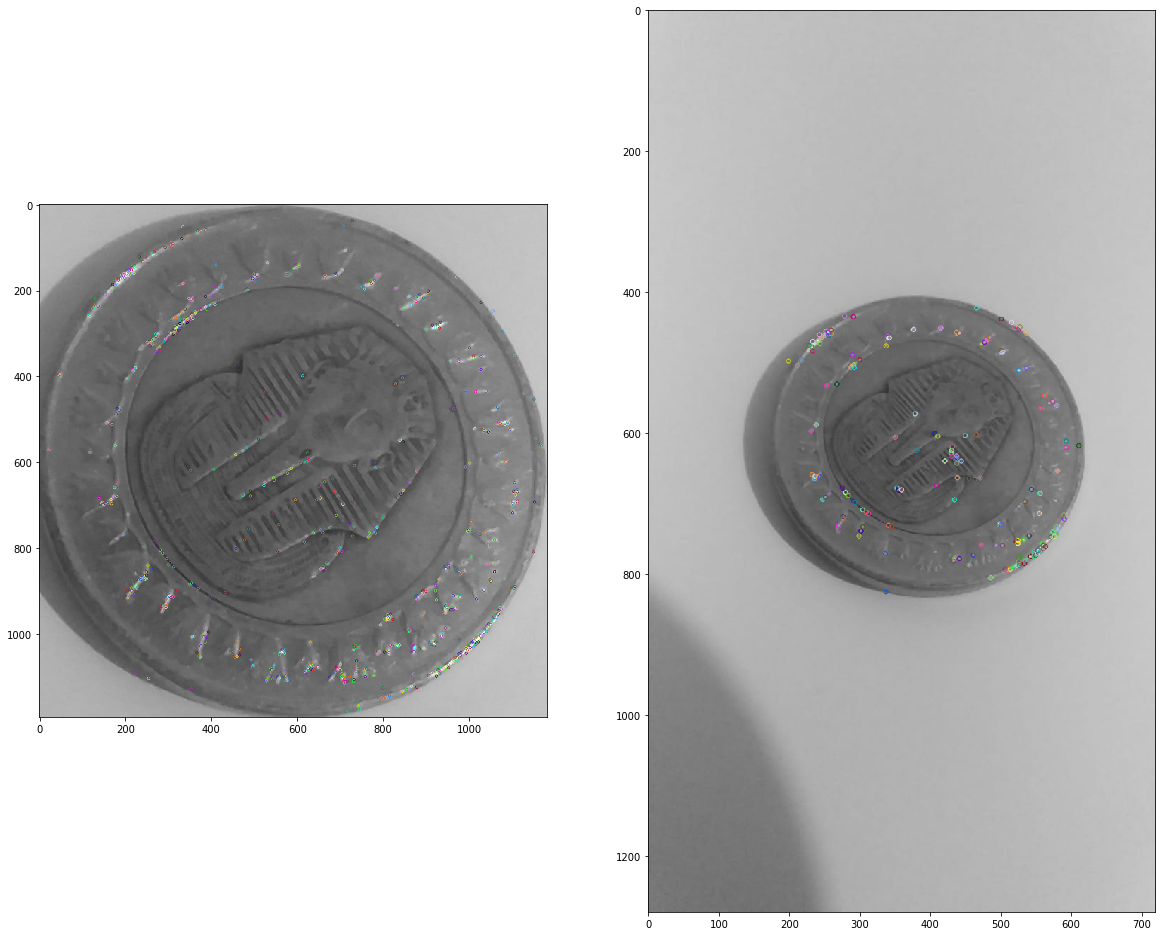

In [6]:
#outImage=cv.drawKeypoints(image,kp,outImage,color,flags)
img1=cv2.drawKeypoints(img1,kp1,img1)
img2=cv2.drawKeypoints(img2,kp2,img2)

plt.figure(figsize=(20,20))



plt.subplot(1,2,1)
plt.imshow(img1)

plt.subplot(1,2,2)
plt.imshow(img2)

##### Feature Matching

In [7]:
#Flann
FLANN_INDEX_LSH = 1
index_params = dict(algorithm=0, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [8]:
#matches = flann.knnMatch(descriptors1, descriptors2, k)
matches = flann.knnMatch(dp1, dp2, k=2)
len(matches)

802

In [9]:
for m,n in matches:
    print("m.distance = ",m.distance," n.distance = ",n.distance)

m.distance =  280.0018005371094  n.distance =  282.6446533203125
m.distance =  262.3032531738281  n.distance =  321.2117614746094
m.distance =  353.5958251953125  n.distance =  355.9915771484375
m.distance =  294.1836242675781  n.distance =  294.818603515625
m.distance =  168.60011291503906  n.distance =  174.20677185058594
m.distance =  163.8230743408203  n.distance =  164.34414672851562
m.distance =  264.33880615234375  n.distance =  301.4365539550781
m.distance =  242.4108123779297  n.distance =  256.9396667480469
m.distance =  159.2011260986328  n.distance =  192.08071899414062
m.distance =  206.0194091796875  n.distance =  216.01388549804688
m.distance =  203.01231384277344  n.distance =  220.80308532714844
m.distance =  182.76214599609375  n.distance =  204.47982788085938
m.distance =  205.88832092285156  n.distance =  239.1484832763672
m.distance =  157.52459716796875  n.distance =  177.36685180664062
m.distance =  233.49732971191406  n.distance =  261.59893798828125
m.distance 

In [10]:
good = []
for m,n in matches:
    if m.distance < 0.6*n.distance:
        good.append(m)
len(good)       
#img3 = cv2.drawMatches(img,kp1,train_img,kp2,good,None,flags=2)
#plt.figure(figsize=(20,20))
#plt.imshow(img3)

7

### Homography

In [11]:
#cv.FindHomography(srcPoints, dstPoints, method=0, ransacReprojThreshold=3.0)
query_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)

train_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

matrix, mask = cv2.findHomography(query_pts, train_pts, cv2.RANSAC, 5.0)

matches_mask = mask.ravel().tolist()

In [12]:
print("matrix shape => ",matrix.shape)
print("------------------------------")
print("matrix \n",matrix)
print("------------------------------")
print("mask shape => ",mask.shape)
print("------------------------------")
print("len (matches_mask) => ",len(matches_mask))
print("------------------------------")
print("matches_mask \n",matches_mask)

matrix shape =>  (3, 3)
------------------------------
matrix 
 [[ 3.75038101e-01  2.00455612e-02  1.51664808e+02]
 [-3.26176997e-02  3.08757488e-01  4.29269034e+02]
 [ 1.70571866e-05 -5.57367698e-05  1.00000000e+00]]
------------------------------
mask shape =>  (7, 1)
------------------------------
len (matches_mask) =>  7
------------------------------
matches_mask 
 [0, 0, 1, 1, 1, 1, 1]


In [13]:
print("------------------------------")
print("number ot outliers = ", matches_mask.count(0))
print("------------------------------")
print("number ot inliers = ", matches_mask.count(1))

------------------------------
number ot outliers =  2
------------------------------
number ot inliers =  5


# Warp Perspective

In [14]:
h, w ,channel= img1.shape
pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
print("pts shape => ",pts.shape)
print("------------------------------")
print("pts \n",pts)
print("------------------------------")

pts shape =>  (4, 1, 2)
------------------------------
pts 
 [[[   0.    0.]]

 [[   0. 1193.]]

 [[1180. 1193.]]

 [[1180.    0.]]]
------------------------------


#### cv2.warpPerspective(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]])


In [15]:
#img2 = cv2.warpPerspective(img2, matrix,(img1.shape[1], img1.shape[0]))
dst = cv2.perspectiveTransform(pts, matrix)
print("dst shape => ",dst.shape)
print("------------------------------")
print("dst \n",dst)
print("------------------------------")

dst shape =>  (4, 1, 2)
------------------------------
dst 
 [[[151.66481 429.26904]]

 [[188.08572 854.4312 ]]

 [[648.17786 796.0373 ]]

 [[582.4858  383.06992]]]
------------------------------


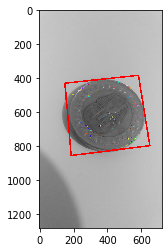

In [16]:
homography = cv2.polylines(img2, [np.int32(dst)], True, (255, 0, 0), 7)
plt.imshow(homography)

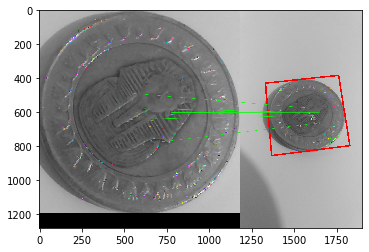

In [17]:
draw_params = dict( matchColor = (0,255,0),# draw matches in green color
                   singlePointColor = None,
                   matchesMask = matches_mask, # draw only inliers
                   flags = 2)

img4 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img4, 'gray')